# Pipeline to predict popularity of a song on spotify based on 2022 data

In [1]:
import sys
sys.path.append(r'C:\Users\bakwe\Documents\GitHub\Git extra\Final_project_Arianna_Vanessa_Tatiana\spotify_library')
import spotify_library 
from spotify_library.features.data_loading import *
from spotify_library.features.data_preprocessing import *
from spotify_library.features.EDA import *
from spotify_library.features.data_splitting import *
from spotify_library.features.feature_engineering import *

In [2]:
# load the spotify data of 2022 as df
df = loaddata(r'C:\Users\bakwe\Documents\GitHub\Git extra\Final_project_Arianna_Vanessa_Tatiana/reduced_spotify_2022.csv')

In [3]:
# check missing values
missing_data = missing_values_table(df)

Dataframe has 20 columns.
There are 0 columns that have missing values.


In [4]:
# drop unnecessary columns: track_id and Unnamed: 0
df = drop_columns(data = df, columns_to_drop=['track_id', 'Unnamed: 0'])

## Exploratory Data Analysis

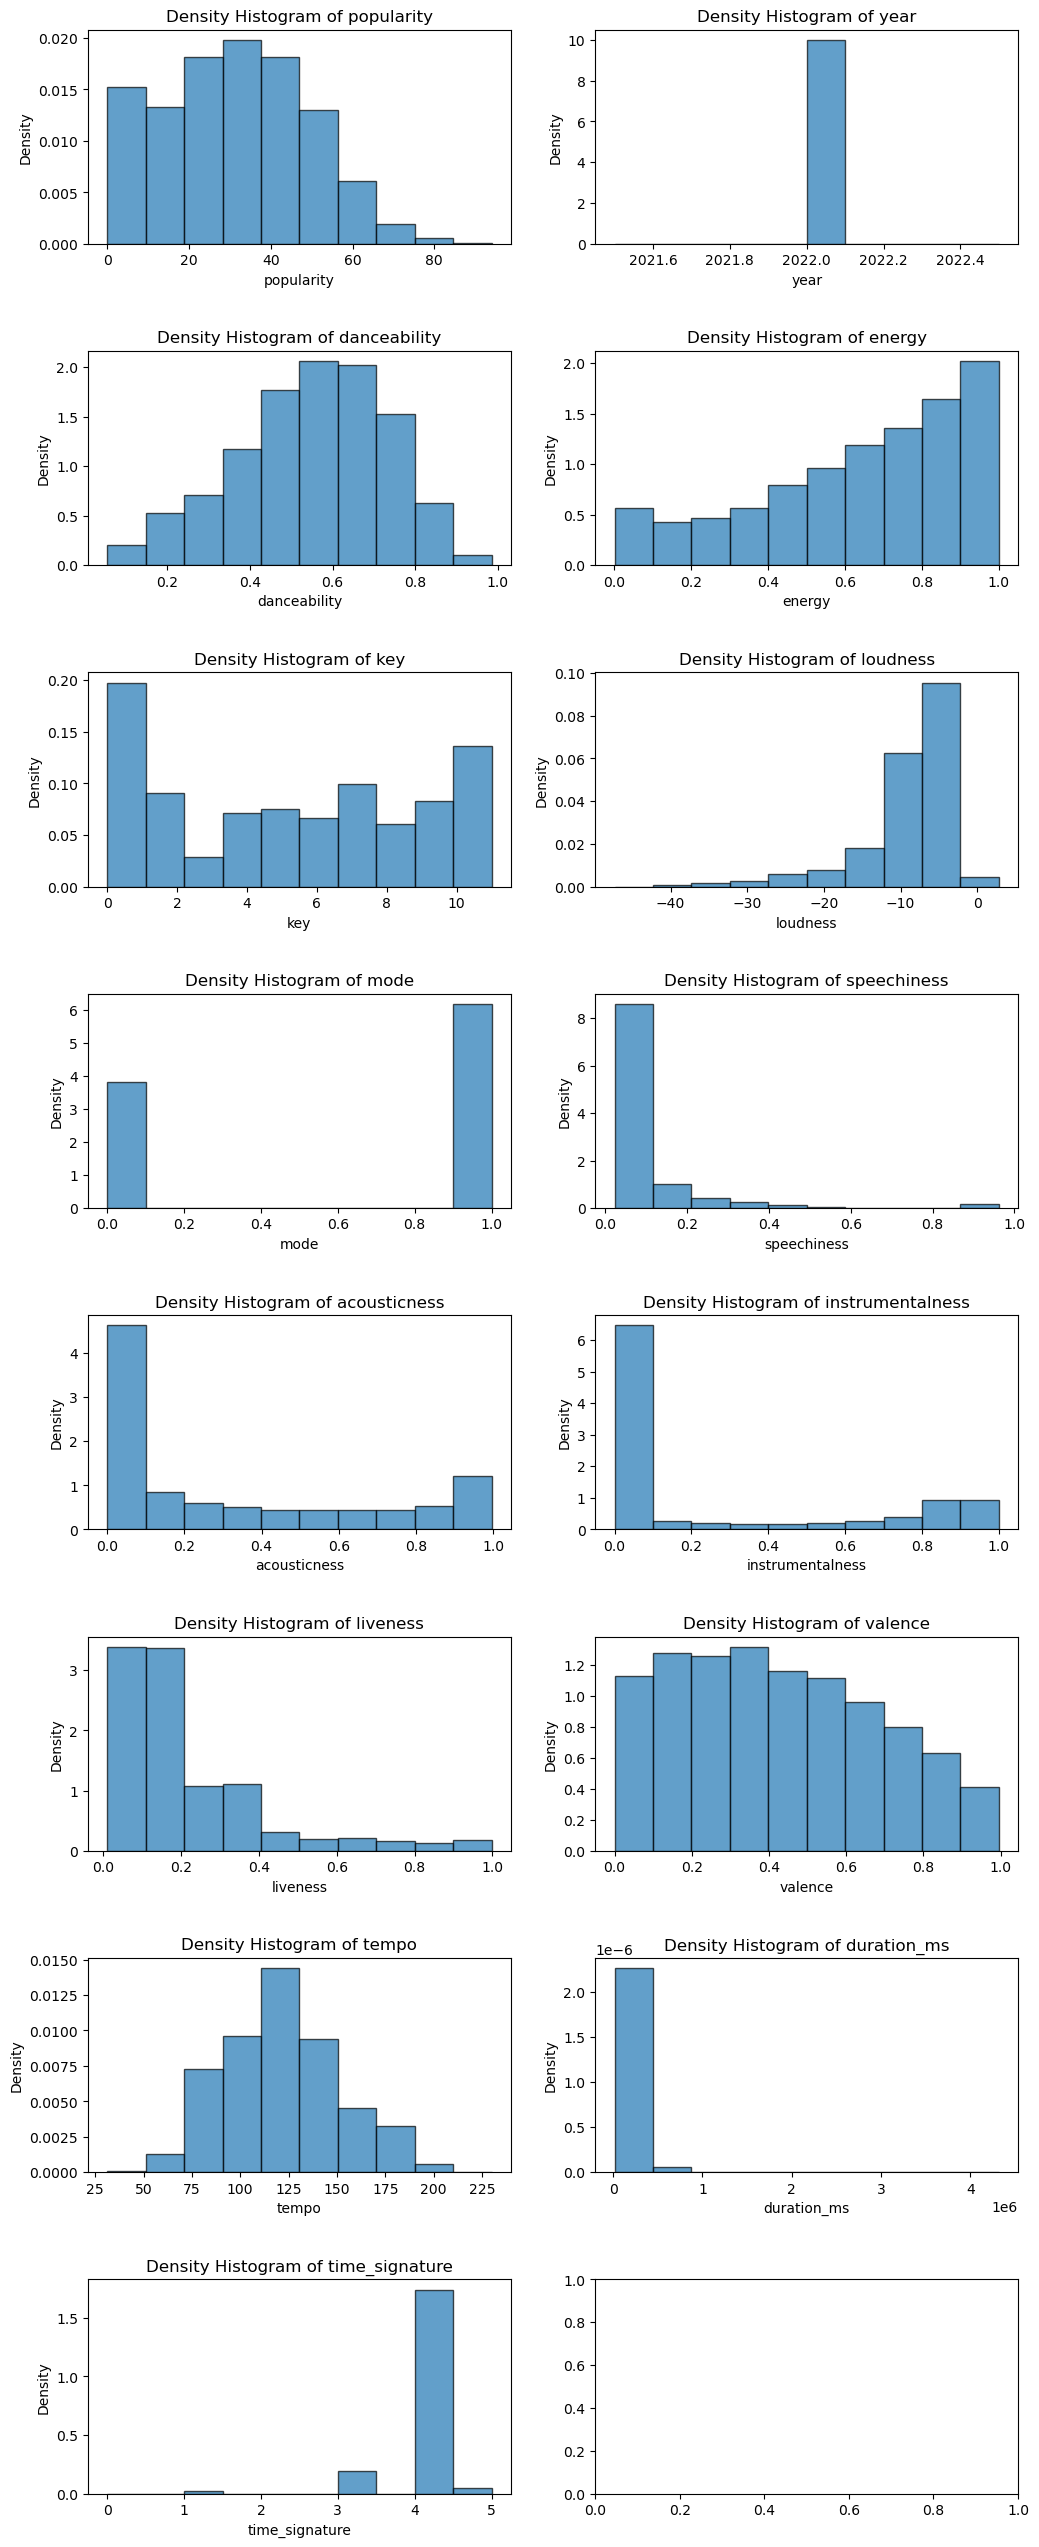

In [5]:
# plot histogram for numerical variables
columns = ['popularity', 'year', 'danceability', 'energy', 'key', 'loudness', 'mode',
           'speechiness', 'acousticness', 'instrumentalness', 'liveness',
           'valence', 'tempo', 'duration_ms', 'time_signature']
hist = hist(df, columns, bins=10, plots_per_row=2).plot_distribution()

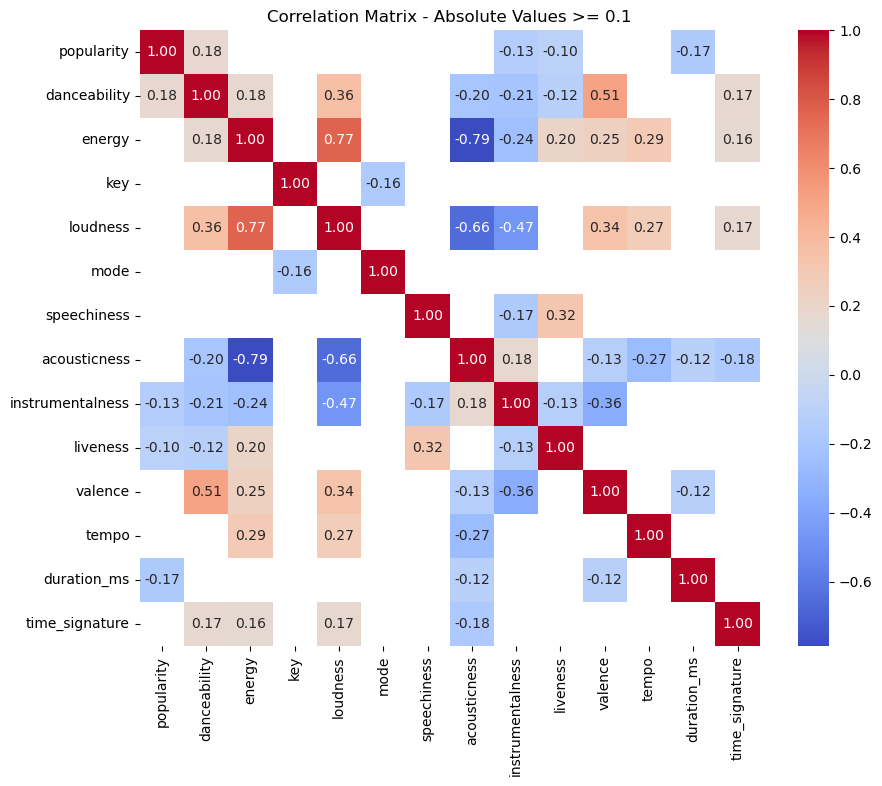

In [6]:
variables_list = ['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
                  'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                  'valence', 'tempo', 'duration_ms', 'time_signature']
corr = correlations(df, variables_list, threshold=0.1).plot_correlation_heatmap()

In [7]:
# Calculate unique counts for the specified columns
count = unique_count(df, columns = ['track_name', 'artist_name', 'genre']).calculate_unique_counts()

Number of unique values in track_name: 49110
Number of unique values in artist_name: 12779
Number of unique values in genre: 82


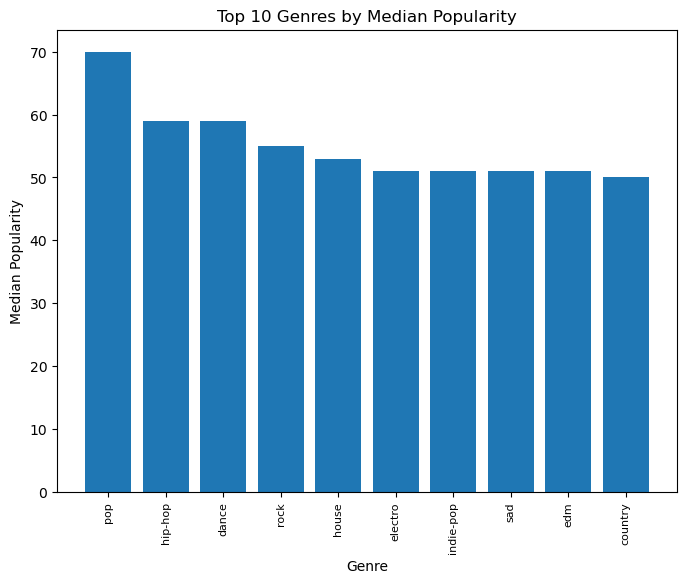

In [8]:
plot = bar_plot_grouped(df, 'genre', 'popularity', 'median', top_n=10).bar_plot()

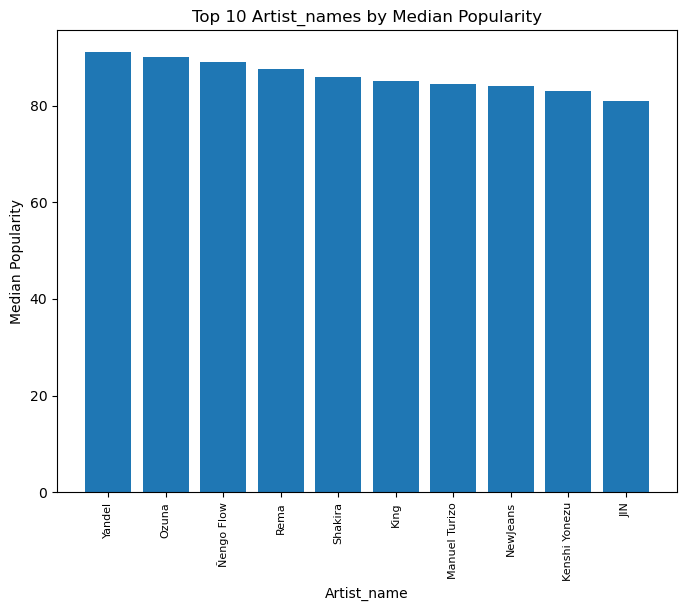

In [9]:
plot = bar_plot_grouped(df, 'artist_name', 'popularity', 'median', top_n=10).bar_plot()

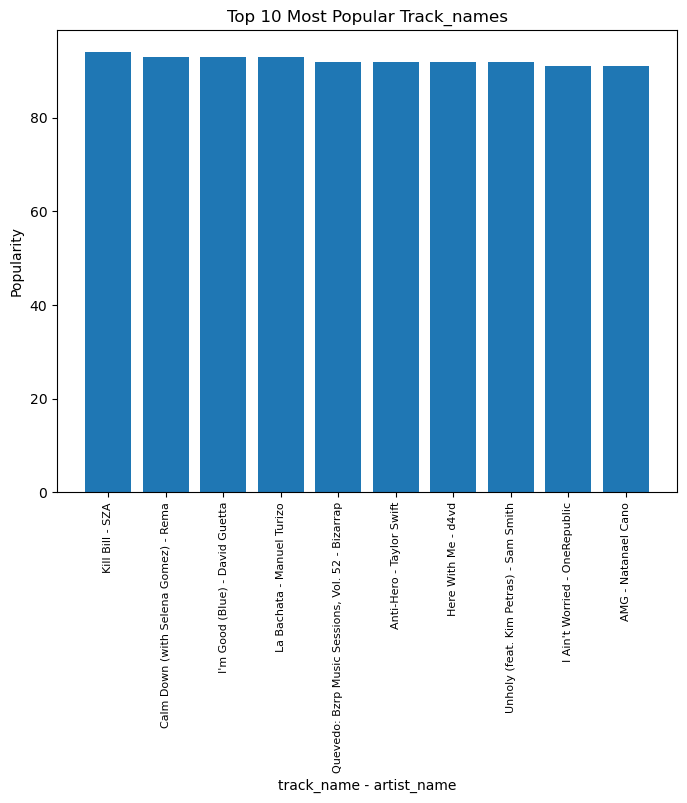

In [10]:
tracks = plot_top(df, top_n = 10).plot_top_items('track_name', 'artist_name', 'popularity')

Plan to add some more EDA functions later on (important ones - boxplots and popularity outliers).

## Data Prepsocessing and Feature Generation

Have not done yet: creating additional rows (feat/with - it looks cool, but could create some confusion); creating 'long_name' and 'night_song' features.

In [11]:
# transform column duration_ms to a column where the duration is in minutes
df = transform_ms_to_minutes(df, 'duration_ms')

In [12]:
# # to consider the effect of certain keywords in the trackname on the popularity, binary columns for given keywords are created 
# df = create_binary_columns_for_keywords(df, 'track_name')

In [13]:
# # because of the assumption that popularity is higher when the songs are also played in bars and clubs a variable will be invented: party_music
# df = add_party_music_column(df)

In [14]:
# Create dummy variables for 'genre'
# For regression we will not need to add 'genre' as a feature
df = one_hot(df, 'genre')

In [15]:
# Execute target encoding for the column 'artist_name'
df = add_mean_column(df, 'artist_name', 'speechiness', 'mean_speechiness')

In [16]:
# Tokenize and count the words in a 'track_name' column
top_100_words = get_top_words(df, 'track_name', top_n=100)
print(top_100_words)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Manually get the list with the most popular meaningful words
words_list = ['remix', 'feat', 'live', 'love', 'my', 'vivo', 'mix', 'version', 'remastered', 'your', 'hardstyle', 'we', 'edit', 'piano', 'like', 'one', 'night', 'life', 'go', 'rain', 'good', 'let', 'mixed', 'acoustic', 'sleep', 'original', 'world', 'new', 'remaster', 'never', 'die']

In [ ]:
# Create dummies with the value 1, if the value in the column 'track_name' contains phrase from the list 'words_list', and 0 otherwise
df_with_dummies = create_dummy_variables(df, 'track_name', words_list)

In [ ]:
columns = words_list
calculate_value_counts(df, columns, top_n=10)

   remix  Count  Percentage
0      0  51656   96.208001
1      1   2036    3.791999
   feat  Count  Percentage
0     0  51967   96.787231
1     1   1725    3.212769
   live  Count  Percentage
0     0  52219   97.256575
1     1   1473    2.743425
   love  Count  Percentage
0     0  52368   97.534083
1     1   1324    2.465917
   my  Count  Percentage
0   0  52368   97.534083
1   1   1324    2.465917
   vivo  Count  Percentage
0     0  52576   97.921478
1     1   1116    2.078522
   mix  Count  Percentage
0    0  50497   94.049393
1    1   3195    5.950607
   version  Count  Percentage
0        0  52779    98.29956
1        1    913     1.70044
   remastered  Count  Percentage
0           0  53072   98.845266
1           1    620    1.154734
   your  Count  Percentage
0     0  53055   98.813604
1     1    637    1.186396
   hardstyle  Count  Percentage
0          0  53282   99.236385
1          1    410    0.763615
   we  Count  Percentage
0   0  52270   97.351561
1   1   1422    2.64843

In [ ]:
print(list(df.columns))

['artist_name', 'track_name', 'popularity', 'year', 'genre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'duration_minutes', 'acoustic', 'afrobeat', 'alt-rock', 'ambient', 'black-metal', 'blues', 'breakbeat', 'cantopop', 'chicago-house', 'chill', 'classical', 'club', 'comedy', 'country', 'dance', 'dancehall', 'death-metal', 'deep-house', 'detroit-techno', 'disco', 'drum-and-bass', 'dub', 'dubstep', 'edm', 'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk', 'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove', 'guitar', 'hard-rock', 'hardcore', 'hardstyle', 'heavy-metal', 'hip-hop', 'house', 'indian', 'indie-pop', 'industrial', 'jazz', 'k-pop', 'metal', 'metalcore', 'minimal-techno', 'new-age', 'opera', 'party', 'piano', 'pop', 'pop-film', 'power-pop', 'progressive-house', 'psych-rock', 'punk', 'punk-rock', 'rock', 'rock-n-roll', 'romance', 'sad', 'salsa', 